# Perovskites

In this notebook, we demonstrate some of the initial work on this project that was carried out in the summer of 2021. Here, we leverage some Xenonpy-calculated properties to calculate the unit cell volume of several perovskite systems taken from NOMAD's database.

Both SISSO and TPOT are used to train predictive models, and near the end of the document we discuss what we can learn from this comparison.

Overall, in this notebook we demonstrate SISSO's ability to generate simple, interpretable models that can help lead us to physical insight - one of the major strengths of symbolic regression.

In [1]:
import functools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tpot
import sklearn
import optuna
import xgboost
import pymatgen
import xenonpy.descriptor
from tqdm.notebook import tqdm 
import sys, os

sys.path.append("../../../")
import DigitalEcosystem.utils.figures
from DigitalEcosystem.utils.functional import except_with_default_value
from DigitalEcosystem.utils.misc import matminer_descriptors
from DigitalEcosystem.utils.element_symbols import noble_gases, f_block_elements, synthetic_elements_in_d_block

from IPython.display import Latex

pd.options.mode.chained_assignment = None 
tqdm.pandas()

In [2]:
# Random seeds for reproducibility
RANDOM_SEED = 42
import random
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Plot Configuration
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams["font.size"] = 32

# Read in the Data

Read the data

In [5]:
data = pd.read_pickle('../feature_engineering/full_featurized_data.pkl')


# Drop any missing entries
target_column = ["bandgap (eV)"]
data = data[data[target_column[0]].notna()]

# # Drop anything in the f-block, larger than U, and noble gases
bad_elements = noble_gases + f_block_elements + synthetic_elements_in_d_block
element_mask = data['atoms_object (unitless)'].apply(lambda atoms: all([forbidden not in atoms.get_chemical_symbols() for forbidden in bad_elements]))

# Drop anything that decomposes
decomposition_mask = data['decomposition_energy (eV/atom)'] < 0.5

# Drop things with non-strictly-positive exfoliation energies
exfol_mask = data['exfoliation_energy_per_atom (eV/atom)'] > 0

data = data[element_mask & decomposition_mask & exfol_mask]

# A parent Materials Project structure is not defined for the bottom-up materials. We waste our bandwith looking these up, so let's remove them.
data = data[data['discovery_process (unitless)'] != 'bottom-up']

In [6]:
rester = pymatgen.ext.matproj.MPRester(api_key=os.getenv("MATERIALS_PROJECT_API_KEY"))


@except_with_default_value(default_return=None)
def get_mp_bandgap(structure):
    mp_id = DigitalEcosystem.utils.misc.get_parent_structure_id(structure)
    
    result = rester.get_data(mp_id, prop='band_gap')[0]['band_gap']
    return result
    
data['mp_bandgap'] = data['2dm_id (unitless)'].progress_apply(get_mp_bandgap)

  0%|          | 0/1879 [00:00<?, ?it/s]

In [9]:
# The above featurization takes a while, so let's just save it to disk
data.to_pickle('filtered_data_with_bandgap.pkl')
#data = pd.read_pickle('filtered_data_with_bandgap.pkl')

In [13]:
# Finally, we'll filter the data with missing values for bandgap
data = data[data['mp_bandgap'].notna()]

In [15]:
xenonpy_descriptors = [col for col in data.columns if ":" in col]

descriptors = xenonpy_descriptors + matminer_descriptors + ['mp_bandgap']

# Prepare Data

In [34]:
train, test = sklearn.model_selection.train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)

train_x = np.nan_to_num(train[descriptors].to_numpy())
train_y = np.nan_to_num(train[target_column].to_numpy())

test_x = np.nan_to_num(test[descriptors].to_numpy())
test_y = np.nan_to_num(test[target_column].to_numpy())

In [35]:
def rmse(y_true, y_pred):
    mse = sklearn.metrics.mean_squared_error(y_true=y_true, y_pred=y_pred)
    rmse = np.sqrt(abs(mse))
    return rmse

metrics = {
    'MaxError': sklearn.metrics.max_error,
    'MAE': sklearn.metrics.mean_absolute_error,
    'MSE': sklearn.metrics.mean_squared_error,
    'RMSE': rmse,
    'MAPE': sklearn.metrics.mean_absolute_percentage_error,
    'R2': sklearn.metrics.r2_score
}

# XGBoost

In [40]:
current_reg = None
best_reg = None
def keep_best_reg(study, trial):
    global best_reg
    if study.best_trial == trial:
        best_reg = current_reg

objective_train_x_reg, objective_validation_x_reg, objective_train_y_reg, objective_validation_y_reg = sklearn.model_selection.train_test_split(
    np.nan_to_num(train_x), train_y, test_size=0.2, random_state=RANDOM_SEED)

def objective(trial: optuna.Trial):
    global current_reg


    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0, 2),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 1, 256),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2)
    }
    
    scalers = {
        "StandardScaler": sklearn.preprocessing.StandardScaler(),
        "MinMaxScaler": sklearn.preprocessing.MinMaxScaler()
    }

    scaler = trial.suggest_categorical('scaler', scalers.keys())

    current_reg = sklearn.pipeline.Pipeline([
        (scaler, scalers[scaler]),
        ("XGB_Regressor", xgboost.sklearn.XGBRegressor(**params,
                                               n_estimators=256,
                                               n_jobs=1,
                                               objective='reg:squarederror',
                                               random_state=RANDOM_SEED),)
    ])

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, f'validation_0-rmse')
    current_reg.fit(X=objective_train_x_reg, y=objective_train_y_reg,
                         **{
                            'XGB_Regressor__eval_set': [[objective_validation_x_reg, objective_validation_y_reg]],
                            'XGB_Regressor__eval_metric': 'rmse',
                            'XGB_Regressor__early_stopping_rounds': 50,
                            'XGB_Regressor__callbacks': [pruning_callback],
                            'XGB_Regressor__verbose': False
                         })

    mse = sklearn.metrics.mean_squared_error(
        y_true=objective_validation_y_reg,
        y_pred=current_reg.predict(objective_validation_x_reg),
    )
    rmse = np.sqrt(mse)

    return rmse

reg_study = optuna.create_study(
    sampler = optuna.samplers.TPESampler(
        seed = RANDOM_SEED,
        warn_independent_sampling = True,
        consider_endpoints = True
    ),
    pruner = optuna.pruners.HyperbandPruner(
        min_resource=1,
        max_resource=256),
    direction='minimize')

reg_study.optimize(func=objective, n_trials=1000, callbacks=[keep_best_reg])

[I 2021-10-05 16:11:44,211] A new study created in memory with name: no-name-b3e851b0-7784-4523-b1a0-62fb039f333b
[I 2021-10-05 16:11:48,100] Trial 0 finished with value: 0.7336210129406551 and parameters: {'learning_rate': 0.749080237694725, 'min_split_loss': 1.9014286128198323, 'max_depth': 188, 'min_child_weight': 5.986584841970366, 'reg_lambda': 0.31203728088487304, 'reg_alpha': 0.3119890406724053, 'scaler': 'MinMaxScaler'}. Best is trial 0 with value: 0.7336210129406551.
[I 2021-10-05 16:11:49,707] Trial 1 finished with value: 0.729603568677646 and parameters: {'learning_rate': 1.2022300234864176, 'min_split_loss': 1.416145155592091, 'max_depth': 6, 'min_child_weight': 9.699098521619943, 'reg_lambda': 1.6648852816008435, 'reg_alpha': 0.4246782213565523, 'scaler': 'MinMaxScaler'}. Best is trial 1 with value: 0.729603568677646.
[I 2021-10-05 16:11:49,982] Trial 2 pruned. Trial was pruned at iteration 3.
[I 2021-10-05 16:11:50,130] Trial 3 pruned. Trial was pruned at iteration 1.
[I 

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


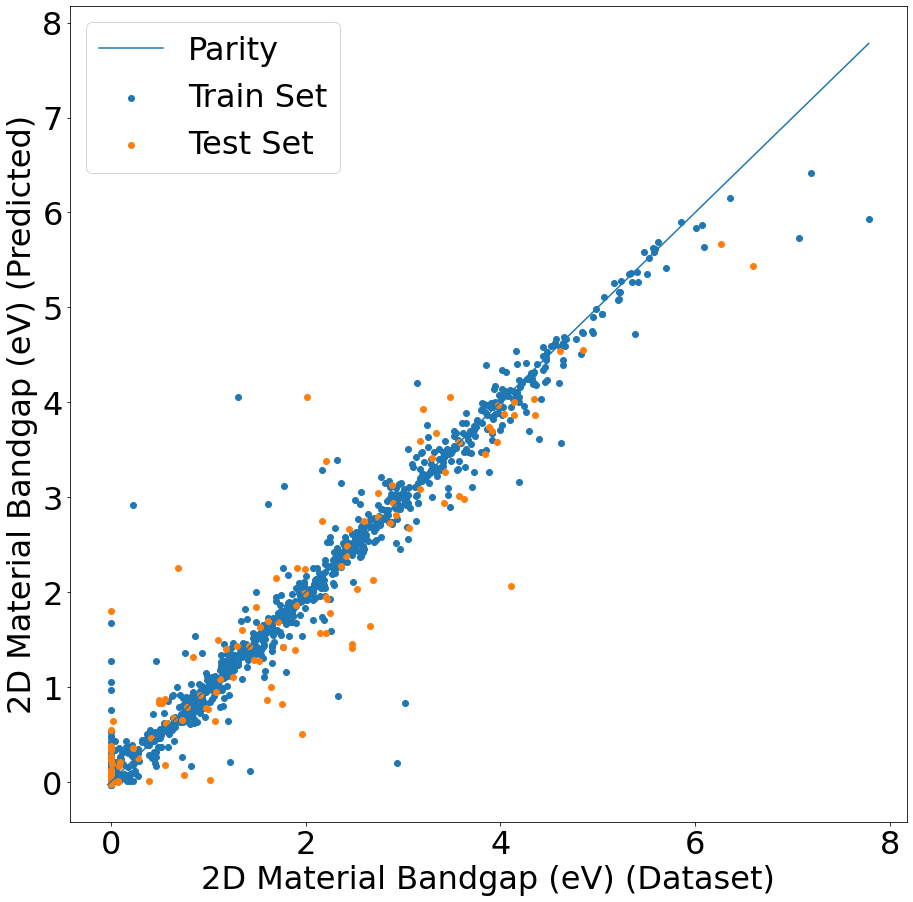

In [51]:
DigitalEcosystem.utils.figures.publication_parity_plot(train_y_true = train_y,
                                                       train_y_pred = best_reg.predict(train_x),
                                                       test_y_true = test_y,
                                                       test_y_pred = best_reg.predict(test_x),
                                                       axis_label = "2D Material Bandgap (eV)",
                                                       filename = "xgboost_2dm_bandgap_parity.jpeg")

In [46]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=best_reg.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=best_reg.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 2.041
MAE 0.3108
MSE 0.248
RMSE 0.498
MAPE 159555155287487.56
R2 0.8923

Training Set Error Metrics
MaxError 2.7507
MAE 0.1168
MSE 0.0642
RMSE 0.2534
MAPE 72957204032215.34
R2 0.9729


# TPOT

In [9]:
tpot_model = tpot.TPOTRegressor(
    generations=10,
    population_size=100,
    max_eval_time_mins=10 / 60,
    cv=10,
    verbosity=2,
    scoring="neg_root_mean_squared_error",
    config_dict=tpot.config.regressor_config_dict,
    n_jobs=-1,
    random_state=1234
)

tpot_model.fit(train_x, train_y.ravel())

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -4.717022046092263

Generation 2 - Current best internal CV score: -4.717022046092263

Generation 3 - Current best internal CV score: -4.717022046092263

Generation 4 - Current best internal CV score: -4.5102759479159085

Generation 5 - Current best internal CV score: -4.5102759479159085

Generation 6 - Current best internal CV score: -4.5102759479159085

Generation 7 - Current best internal CV score: -4.5102759479159085

Generation 8 - Current best internal CV score: -4.5102759479159085

Generation 9 - Current best internal CV score: -4.5102759479159085

Generation 10 - Current best internal CV score: -4.441210252154802

Best pipeline: RidgeCV(StandardScaler(XGBRegressor(DecisionTreeRegressor(input_matrix, max_depth=2, min_samples_leaf=9, min_samples_split=19), learning_rate=0.5, max_depth=3, min_child_weight=15, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.1, verbosity=0)))


TPOTRegressor(config_dict={'sklearn.cluster.FeatureAgglomeration': {'affinity': ['euclidean',
                                                                                 'l1',
                                                                                 'l2',
                                                                                 'manhattan',
                                                                                 'cosine'],
                                                                    'linkage': ['ward',
                                                                                'complete',
                                                                                'average']},
                           'sklearn.decomposition.FastICA': {'tol': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                           'sklearn.decomposition.PCA': {'iter

/Users/mat3ra/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


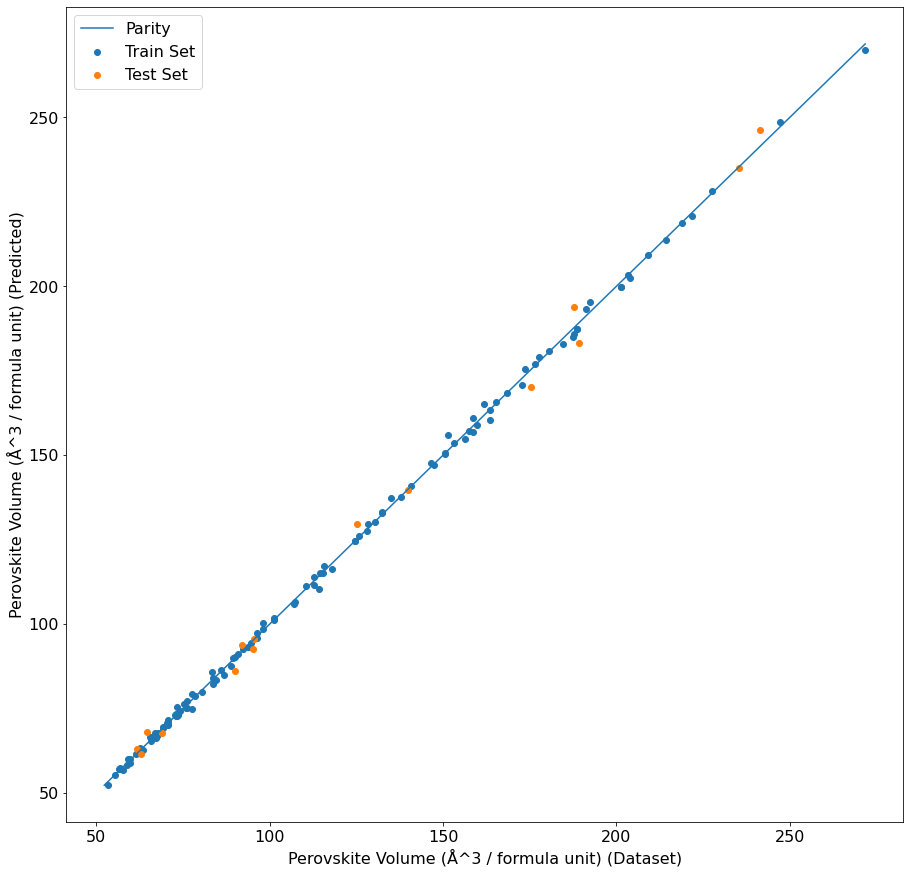

In [10]:
DigitalEcosystem.utils.figures.save_parity_plot(train_x,
                                                test_x,
                                                train_y,
                                                test_y,
                                                tpot_model,
                                                "Perovskite Volume (Å^3 / formula unit)",
                                                "tpot_perovskite_volume_parity.jpeg")

In [11]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=test_y, y_pred=tpot_model.predict(test_x))
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=train_y, y_pred=tpot_model.predict(train_x))
    print(key,np.round(value,4))

Test Set Error Metrics
MaxError 6.1322
MAE 2.8771
MSE 12.3533
RMSE 3.5147
MAPE 0.0241
R2 0.9966

Training Set Error Metrics
MaxError 4.7387
MAE 0.9186
MSE 1.5725
RMSE 1.254
MAPE 0.0084
R2 0.9994


# Roost

In [44]:
roost_dir = "./roost"
os.makedirs(roost_dir, exist_ok=True)
roost_data_train = train[['formula'] + target_column]
roost_data_test = test[['formula'] + target_column]

roost_data_train.to_csv(os.path.join(roost_dir, 'roost_train.csv'), index_label='material_id')
roost_data_test.to_csv(os.path.join(roost_dir, 'roost_test.csv'), index_label='material_id')

At this point, Roost models were run. Logs can be found in the Roost directory, along with the resultant predictions.

In [47]:
roost_train_results = pd.read_csv("roost/roost_train_predictions.csv", index_col="material_id")
roost_test_results  = pd.read_csv("roost/roost_test_predictions.csv", index_col="material_id")

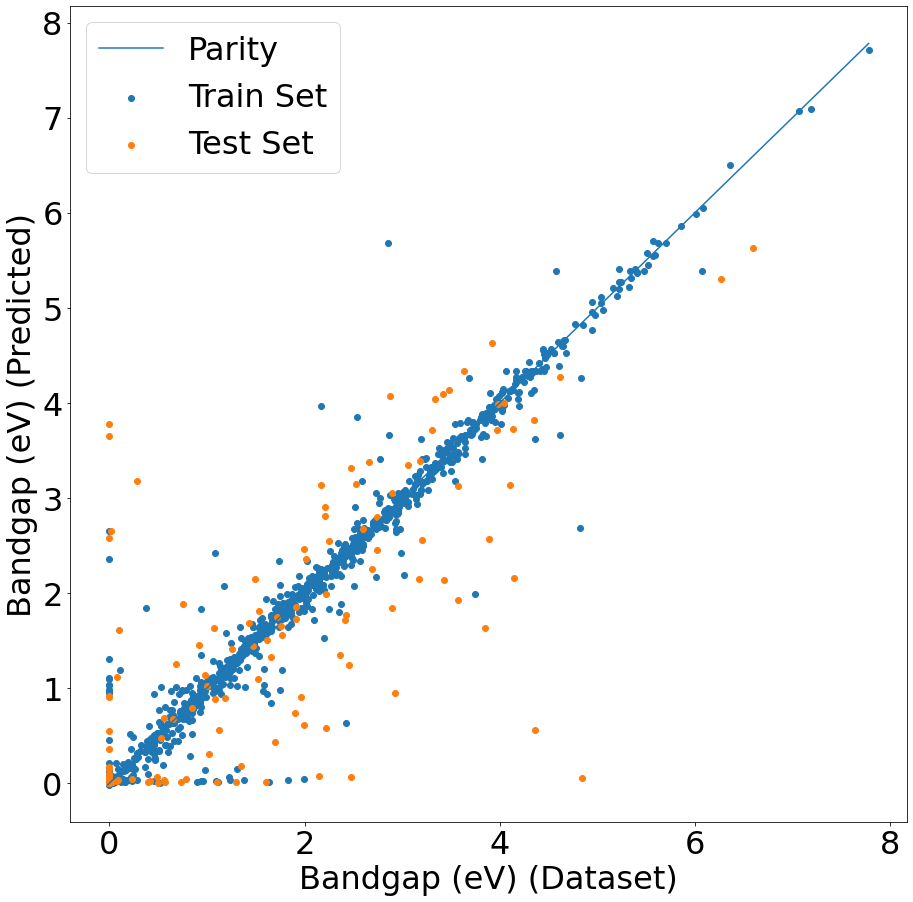

In [49]:
DigitalEcosystem.utils.figures.publication_parity_plot(train_y_true = roost_train_results['bandgap_target'],
                                                       train_y_pred =  roost_train_results['bandgap_pred_n0'],
                                                       test_y_true = roost_test_results['bandgap_target'],
                                                       test_y_pred = roost_test_results['bandgap_pred_n0'],
                                                       axis_label = "Bandgap (eV)",
                                                       filename = "roost_2dm_bandgap_parity.jpeg")

In [52]:
print("Test Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_test_results['volu_target'], y_pred=roost_test_results['volume_pred_n0'])
    print(key,np.round(value,4))
    
print("\nTraining Set Error Metrics")
for key, fun in metrics.items():
    value = fun(y_true=roost_train_results['volume_target'], y_pred=roost_train_results['volume_pred_n0'])
    print(key,np.round(value,4))

Test Set Error Metrics


KeyError: 'volume_target'

# SISSO

Start by obtaining importance scores from the XGBoost model

In [37]:
sisso_feature_selector = sklearn.feature_selection.SelectFromModel(sklearn.linear_model.LassoCV(random_state=RANDOM_SEED),
                                                                   threshold=-np.inf,
                                                                   max_features=16,
                                                                   prefit=False)
sisso_feature_selector.fit(train_x, train_y.ravel())

sisso_features = [col for (col, is_selected) in zip(train[descriptors].columns, sisso_feature_selector.get_support()) if is_selected]
print("\n".join(sisso_features))

ave:Polarizability
ave:atomic_number
ave:atomic_radius
ave:atomic_radius_rahm
ave:atomic_volume
ave:atomic_weight
ave:boiling_point
ave:bulk_modulus
sum:hhi_p
var:boiling_point
var:c6_gb
var:hhi_p
var:hhi_r
var:melting_point
var:sound_velocity
var:thermal_conductivity


In [39]:
sisso_dir = "./sisso"
os.makedirs(sisso_dir, exist_ok=True)

sisso_data_train = train[target_column + sisso_features]
sisso_data_test = test[target_column + sisso_features]

sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_train.csv'), index_label='2dm_id (unitless)')

At this point, a SISSO model was run.

In [39]:
sisso_models = {
    'r1_1term': lambda df: -4.559505163148324e+02 + \
                           2.464859419692384e+00 * (df['ave:atomic_volume'] + df['ave:atomic_radius_rahm']),

    'r1_2term': lambda df: 7.027013257763095e+01 + \
                           -7.832363248251127e-01 * (df['ave:bulk_modulus'] - df['ave:atomic_number']) + \
                           6.564150096290632e-13 * (df['ave:atomic_radius_rahm'] ** 6),
    
    'r1_3term': lambda df: -3.526598287867814e+02 + \
                           -5.798450768280212e-02 * (df['var:c6_gb'] / df['sum:hhi_r']) + \
                           -5.504850208135466e-01 * (np.cbrt(df['var:melting_point'])) + \
                           2.201736063422449e+00 * (df['ave:atomic_volume'] + df['ave:atomic_radius_rahm']),
    
    'r1_4term': lambda df: -2.747502839404784e+02 + \
                           -5.185525800282890e-02 * (df['var:c6_gb'] / df['sum:hhi_p']) + \
                           -7.290004701356699e-19 * (df['ave:boiling_point'] ** 6) + \
                           -4.455507677046804e-01 * (df['ave:bulk_modulus'] - df['ave:atomic_weight']) + \
                           1.699729115030021e+00 * (df['ave:atomic_volume'] + df['ave:atomic_radius_rahm']),
    
    'r2_1term': lambda df: -2.729296923117930e+01 + \
                           -3.137476417692739e-03 * ((df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm']) * (df['ave:atomic_weight'] + df['ave:atomic_radius_rahm'])),
    
    'r2_2term': lambda df: -2.063184570690620e+01 + \
                           -1.686398694159229e+04 * ((df['var:c6_gb'] / df['ave:bulk_modulus']) / (df['ave:atomic_volume'] ** 6)) + \
                           -3.195005086243114e-03 * ((df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm']) * (df['ave:atomic_weight'] + df['ave:atomic_radius_rahm'])),
    
    'r2_3term': lambda df: -1.510330342353259e+01 + \
                           4.058647378703507e+03 * ((df['var:sound_velocity'] - df['var:hhi_p']) / (df['var:c6_gb'] * df['sum:hhi_r'])) + \
                           -2.139489205523803e+04 * ((df['var:c6_gb'] / df['ave:bulk_modulus']) / df['ave:atomic_volume'] ** 6) + \
                           -3.170219793913757e-03 * ((df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm']) * (df['ave:atomic_weight'] + df['ave:atomic_radius_rahm'])),
    
    'r2_4term': lambda df: -1.199519222577036e+01 + \
                           1.884199571337176e+00 * ((df['ave:boiling_point'] * df['ave:atomic_weight']) / (abs(df['var:melting_point'] - df['sum:hhi_r']))) + \
                           3.941803378766428e+03 * ((df['var:sound_velocity'] - df['var:hhi_p']) / (df['var:c6_gb'] * df['sum:hhi_r'])) + \
                           -2.184309236205812e+04 * ((df['var:c6_gb'] / df['ave:bulk_modulus']) / (df['ave:atomic_volume'] ** 6)) + \
                           -3.048156404473468e-03 * ((df['ave:bulk_modulus'] - df['ave:atomic_radius_rahm']) * (df['ave:atomic_weight'] + df['ave:atomic_radius_rahm']))
}

for key, fun in sisso_models.items():
    print(f"==========\nSISSO Model {key}")
    sisso_train_predictions = fun(sisso_data_train)
    sisso_test_predictions = fun(sisso_data_test)
    sisso_data_train[key] = sisso_train_predictions
    sisso_data_test[key] = sisso_test_predictions
    
    print("\nTest Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_test['Volume'], y_pred=sisso_test_predictions)
        print(metric,np.round(value,4))

    print("\nTraining Set Error Metrics")
    for metric, fun in metrics.items():
        value = fun(y_true=sisso_data_train['Volume'], y_pred=sisso_train_predictions)
        print(metric,np.round(value,4))
    
    


SISSO Model r1_1term

Test Set Error Metrics
MaxError 30.4303
MAE 10.9498
MSE 181.7224
RMSE 13.4804
MAPE 0.1167
R2 0.9505

Training Set Error Metrics
MaxError 45.9666
MAE 10.5335
MSE 185.425
RMSE 13.6171
MAPE 0.1068
R2 0.9295
SISSO Model r1_2term

Test Set Error Metrics
MaxError 20.8743
MAE 8.2076
MSE 111.5679
RMSE 10.5626
MAPE 0.0762
R2 0.9696

Training Set Error Metrics
MaxError 43.27
MAE 8.6229
MSE 144.8684
RMSE 12.0361
MAPE 0.0799
R2 0.945
SISSO Model r1_3term

Test Set Error Metrics
MaxError 12.9685
MAE 5.3643
MSE 43.2774
RMSE 6.5786
MAPE 0.0489
R2 0.9882

Training Set Error Metrics
MaxError 40.9966
MAE 7.5233
MSE 116.332
RMSE 10.7857
MAPE 0.0696
R2 0.9558
SISSO Model r1_4term

Test Set Error Metrics
MaxError 20.5222
MAE 7.7086
MSE 87.59
RMSE 9.359
MAPE 0.0659
R2 0.9761

Training Set Error Metrics
MaxError 44.3724
MAE 7.7689
MSE 109.574
RMSE 10.4678
MAPE 0.0756
R2 0.9584
SISSO Model r2_1term

Test Set Error Metrics
MaxError 15.0489
MAE 7.426
MSE 71.3617
RMSE 8.4476
MAPE 0.0664
R2 

It's not the best model, but we're gonna use the Rung1 1Term model, because it's simple and still performs well. It's also intuitive.

In [48]:
sisso_data_train.to_csv(os.path.join(sisso_dir, 'sisso_results_train.csv'))
sisso_data_test.to_csv(os.path.join(sisso_dir, 'sisso_results_test.csv'))

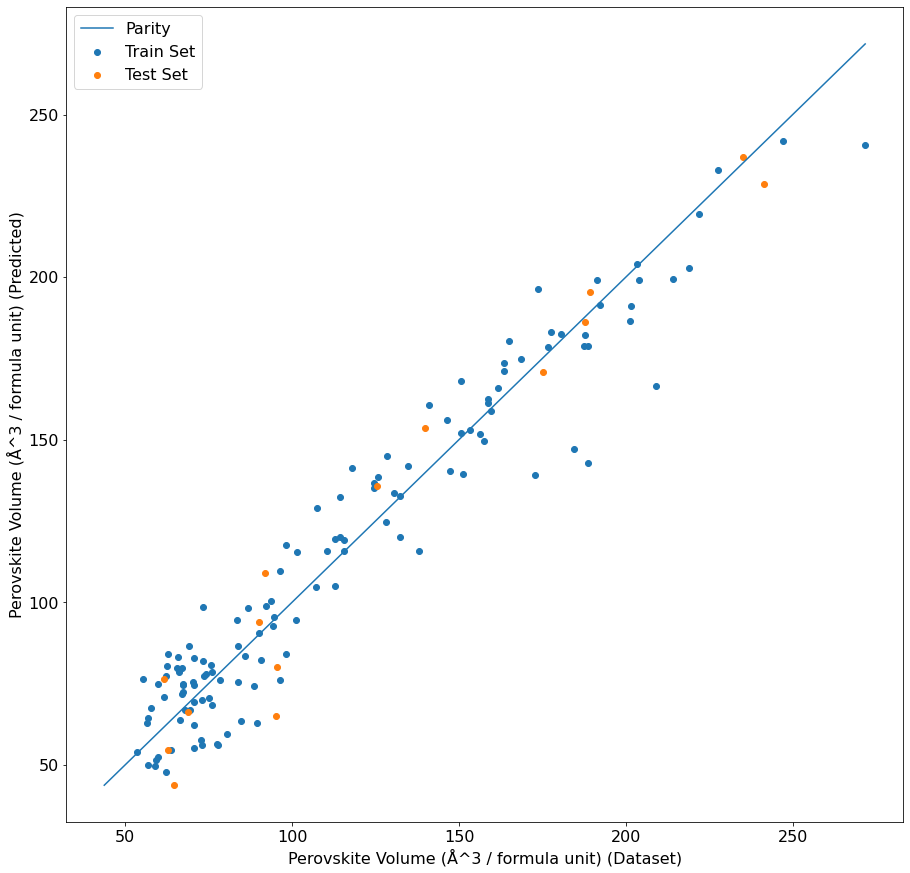

In [45]:
plt.scatter(x=sisso_data_train['Volume'], y=sisso_data_train['r1_1term'], label="Train Set")
plt.scatter(x=sisso_data_test['Volume'], y=sisso_data_test['r1_1term'], label="Test Set")

min_xy = min(min(sisso_data_train['Volume']),
             min(sisso_data_test['Volume']),
             min(sisso_data_train['r1_1term']),
             min(sisso_data_test['r1_1term']))
max_xy = max(max(sisso_data_train['Volume']),
             max(sisso_data_test['Volume']),
             max(sisso_data_train['r1_1term']),
             max(sisso_data_test['r1_1term']))

plt.plot([min_xy, max_xy], [min_xy, max_xy], label="Parity")
plt.ylabel(f"Perovskite Volume (Å^3 / formula unit) (Predicted)")
plt.xlabel(f"Perovskite Volume (Å^3 / formula unit) (Dataset)")
plt.legend()
plt.savefig("sisso_perovskite_volume_parity.jpeg")
plt.show()
plt.close()